## Motivation for Building a Semantic Search Tool

**Semantic search tools** are utilities that facilitate searching for the embedded form of a query within a pre-stored and labeled vector index. However, many of the semantic search tools I've encountered focus strictly on data consistency. In other words, when there is a discrepancy, they return the highest-matching results within the data. 

> But what if the most frequent result in the dataset is just a highly repetitive one?

### Why I Built This Tool

The reason I developed this tool is to prevent **cookies, warnings, popups, and advertisements**—common in web scraping and crawling processes—from being presented to LLM tools as valid content.

To solve this:
1. The content is ranked from **closest to farthest** in terms of embedding similarity.
2. All items at the **same similarity level are first classified among themselves**.
3. These embedded contents are then stacked to form a **vector cube**.
4. A block is extracted from the **topmost, most relevant content**, and this block is fed to the LLM.

By following this process, we reduce the likelihood of sending duplicate or marginally relevant data to the LLM. This in turn helps **minimize hallucinations**, depending on the model's capacity.

---

### FAISS vs. Schemantic

In all my web scraping tests using **FAISS**, cookie contents frequently dominated the top results.

In contrast, all experiments conducted using **Schemantic** successfully surfaced the **actual site content** to the LLM, with much **higher proximity scores** and improved content relevance.

In [39]:
import openai
from dotenv import load_dotenv
import os

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")

records = [
    # Cats
    ("1",  "The cat sits by the fire."),
    ("6",  "A kitten curls up next to the furnace."),
    ("7",  "The feline lounges beside the hearth."),
    ("8",  "A cat naps on the warm rug in front of the fireplace."),
    ("9",  "The pet cat dozes near the living room heater."),
    # Dogs
    ("2",  "A dog sleeps on the sofa."),
    ("10", "The hound slumbers on the couch."),
    ("11", "My puppy is dozing on the living room chair."),
    ("12", "The dog lies sprawled across the couch cushions."),
    ("13", "A canine rests on the comfortable sofa."),
    # Weather
    ("3",  "Weather in Izmit will be sunny."),
    ("4",  "Izmit weather: 20 degrees and sunny."),
    ("14", "Tomorrow Izmit will see clear skies with highs of 19°C."),
    ("15", "Izmit is expected to be bright and warm today."),
    ("16", "Sunny weather and 19 degrees are forecast for Izmit."),
    # Other
    ("5",  "The dog chases the cat."),
    ("17", "She writes code at her desk all night."),
    ("18", "Machine learning models detect patterns in data."),
    ("19", "Deep neural networks are used for image recognition."),
    ("20", "He enjoys painting landscapes in his free time."),
]

In [40]:
def get_openai_embed(text, model="text-embedding-3-small"):
    response = openai.embeddings.create(input=[text], model=model)
    return response.data[0].embedding

print("🔄 Embeddings creating...")
data = [
    (i, get_openai_embed(text), label)
    for i, (label, text) in enumerate(records)
]
print("✅ Embeddings created.")

🔄 Embeddings creating...
✅ Embeddings created.


In [42]:
from sklearn.decomposition import PCA

labels = [label for _, _, label in data]
embeddings = [vec for _, vec, _ in data]

pca = PCA(n_components=2)
reduced = pca.fit_transform(embeddings)

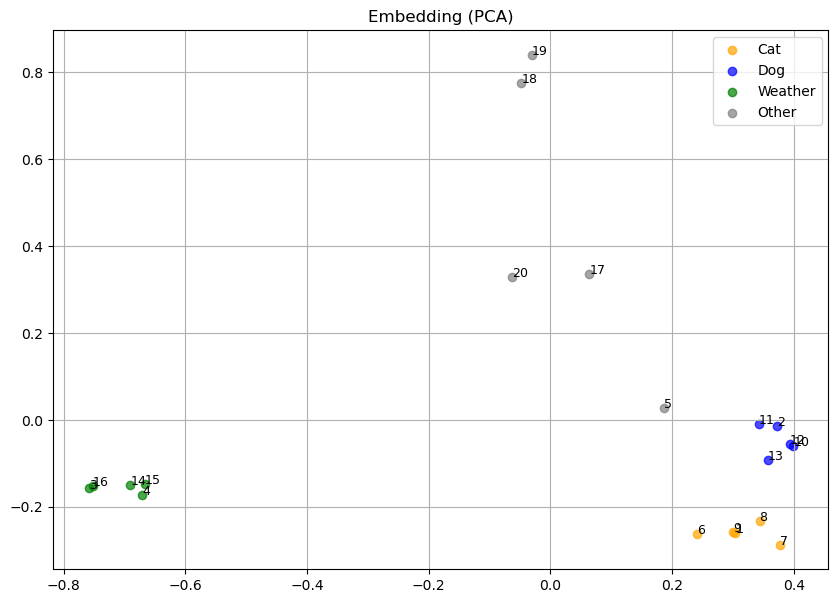

In [43]:
import matplotlib.pyplot as plt

def label_category(label):
    if label in {'1','6','7','8','9'}:
        return 'Cat'
    elif label in {'2','10','11','12','13'}:
        return 'Dog'
    elif label in {'3','4','14','15','16'}:
        return 'Weather'
    return 'Other'

colors = {
    'Cat': 'orange',
    'Dog': 'blue',
    'Weather': 'green',
    'Other': 'gray'
}

plt.figure(figsize=(10, 7))

for (x, y), (_, _, label) in zip(reduced, data):
    category = label_category(label)
    plt.scatter(x, y, color=colors[category], label=category, alpha=0.7)
    plt.text(x, y, label, fontsize=9)

handles, labels_ = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels_, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title("Embedding (PCA)")
plt.grid(True)
plt.show()

In [44]:
from schemantic import same_search
import time

start_time = time.time()
matches = same_search(data, threshold=0.50, brute_force=False)
end_time = time.time()

print(f"\n⏱️ same_search time: {end_time - start_time:.4f} sec.")


⏱️ same_search time: 0.0136 sec.


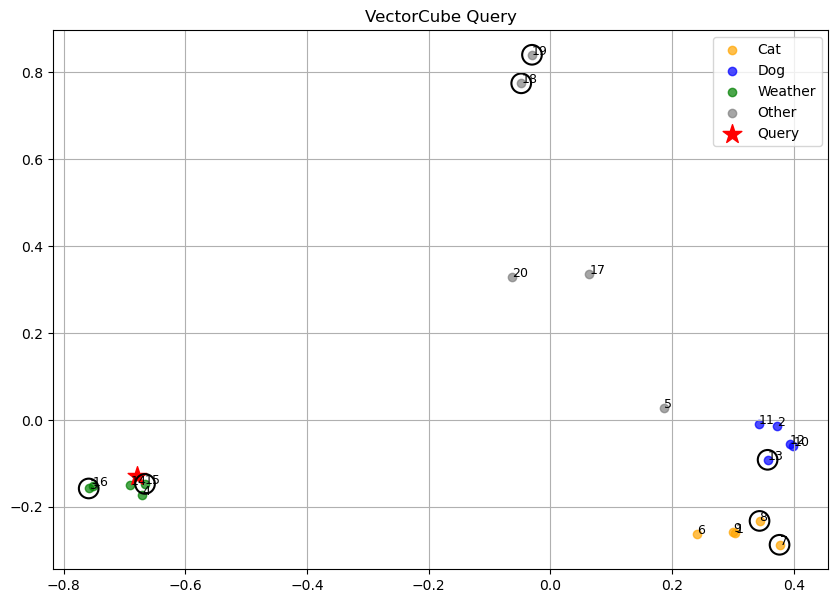


⏱️ Total query time: 0.0011 sec.


In [45]:
from schemantic import VectorCube

cube = VectorCube(data)
query_text = "weather in izmit"
query_embed = get_openai_embed(query_text)

start = time.time()
results = cube.query(query_embed)
end = time.time()



query_reduced = pca.transform([query_embed])[0]

plt.figure(figsize=(10, 7))

# Check the structure of reduced and data before unpacking
# Make sure reduced contains (x,y) pairs and data contains triples
for i, ((x, y), item) in enumerate(zip(reduced, data)):
    # Assuming data items might be structured differently, extract label safely
    if isinstance(item, tuple) and len(item) >= 3:
        _, _, label = item
    elif isinstance(item, dict) and 'label' in item:
        label = item['label']
    else:
        # If structure is unknown, create a default label
        label = f"Item {i}"
        
    category = label_category(label)
    plt.scatter(x, y, color=colors[category], label=category, alpha=0.7)
    plt.text(x, y, label, fontsize=9)

plt.scatter(query_reduced[0], query_reduced[1], color='red', marker='*', s=200, label='Query')

matched_labels = set(results)  # fix: results tek değerlikli ise
for (x, y), (_, _, label) in zip(reduced, data):
    if label in matched_labels:
        plt.scatter(x, y, facecolors='none', edgecolors='black', s=200, linewidths=1.5)

handles, labels_ = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels_, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title("VectorCube Query")
plt.grid(True)
plt.show()

print(f"\n⏱️ Total query time: {end - start:.4f} sec.")

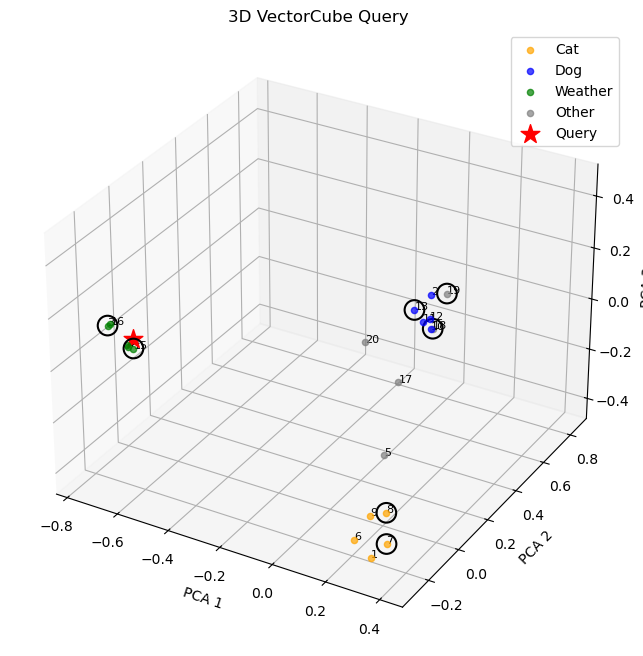

In [46]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

pca_3d = PCA(n_components=3)
reduced_3d = pca_3d.fit_transform(embeddings)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

for (x, y, z), (_, _, label) in zip(reduced_3d, data):
    category = label_category(label)
    ax.scatter(x, y, z, color=colors[category], label=category, alpha=0.7)
    ax.text(x, y, z, label, fontsize=8)

query_reduced_3d = pca_3d.transform([query_embed])[0]
ax.scatter(query_reduced_3d[0], query_reduced_3d[1], query_reduced_3d[2],
           color='red', marker='*', s=200, label='Query')

matched_labels = set(results)
for (x, y, z), (_, _, label) in zip(reduced_3d, data):
    if label in matched_labels:
        ax.scatter(x, y, z, facecolors='none', edgecolors='black', s=200, linewidths=1.5)

handles, labels_ = ax.get_legend_handles_labels()
by_label = dict(zip(labels_, handles))
ax.legend(by_label.values(), by_label.keys())

ax.set_title("3D VectorCube Query")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")

plt.show()